In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta

from sklearn.decomposition import PCA  # for PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler   # scaling for PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA   # for LDA
from factor_analyzer.factor_analyzer import calculate_kmo       # KMO test
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity     # Bartlett's test

from sklearn.neighbors import NearestNeighbors  # Knee-Elbow method for optimal K
from sklearn.cluster import KMeans     # KMeans clustering
from sklearn.datasets import make_blobs

# This file for data preprocessing tasks and feature engineering

In [3]:
# Hyper parameter values
RANDOM_STATE = 42
scaler_1 = StandardScaler()
scaler_2 = MinMaxScaler()
N_SPLITS = 5
target = 'price'
data_path = 'C:/Users/pragy/OneDrive/Desktop/CDC_Submission Project/dataset'    # path to the data folder (Change for you local system)

In [4]:
df_train = pd.read_csv(data_path + '/train(1)(train(1)).csv')
df_test = pd.read_csv(data_path + '/test2(test(1)).csv')

In [5]:
print("train columns : ", df_train.columns)
print("test columns : ", df_test.columns)
print("Same size : ", df_train.shape == df_test.shape)
if df_train.shape != df_test.shape:
    print(len(df_train.columns) - len(df_test.columns), " columns are different")
    print(list(set(df_train.columns) - set(df_test.columns)))
print("Train data types : \n", df_train.dtypes)
print("Test data types : \n", df_test.dtypes)
print("Train dataset shape : ", df_train.shape)
print("Test dataset shape : ", df_test.shape)

train columns :  Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
test columns :  Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
Same size :  False
1  columns are different
['price']
Train data types : 
 id                 int64
date              object
price              int64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_abov

In [6]:
df_train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,5272200045,20141113T000000,378000,3,1.50,1000,6914,1.0,0,0,...,7,1000,0,1947,0,98125,47.7144,-122.319,1000,6947
16205,9578500790,20141111T000000,399950,3,2.50,3087,5002,2.0,0,0,...,8,3087,0,2014,0,98023,47.2974,-122.349,2927,5183
16206,7202350480,20140930T000000,575000,3,2.50,2120,4780,2.0,0,0,...,7,2120,0,2004,0,98053,47.6810,-122.032,1690,2650
16207,1723049033,20140620T000000,245000,1,0.75,380,15000,1.0,0,0,...,5,380,0,1963,0,98168,47.4810,-122.323,1170,15000


In [7]:
# First we clean the dataset for Date

#Since only date has value and time does not, we first make it string and get first 8 characters
df_train['date'] = df_train['date'].astype(str).str[:8]
df_test['date'] = df_test['date'].astype(str).str[:8]

# now the date is of type %Y%m%d, we convert it to datetime object, first inset /s between year, month and day
df_train['date'] = df_train['date'].str[:4] + '/' + df_train['date'].str[4:6] + '/' + df_train['date'].str[6:8]
df_test['date'] = df_test['date'].str[:4] + '/' + df_test['date'].str[4:6] + '/' + df_test['date'].str[6:8]
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y/%m/%d')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y/%m/%d')

# now we arrange the data in increasing order of date
df_train = df_train.sort_values(by='date').reset_index(drop=True)
df_test = df_test.sort_values(by='date').reset_index(drop=True)

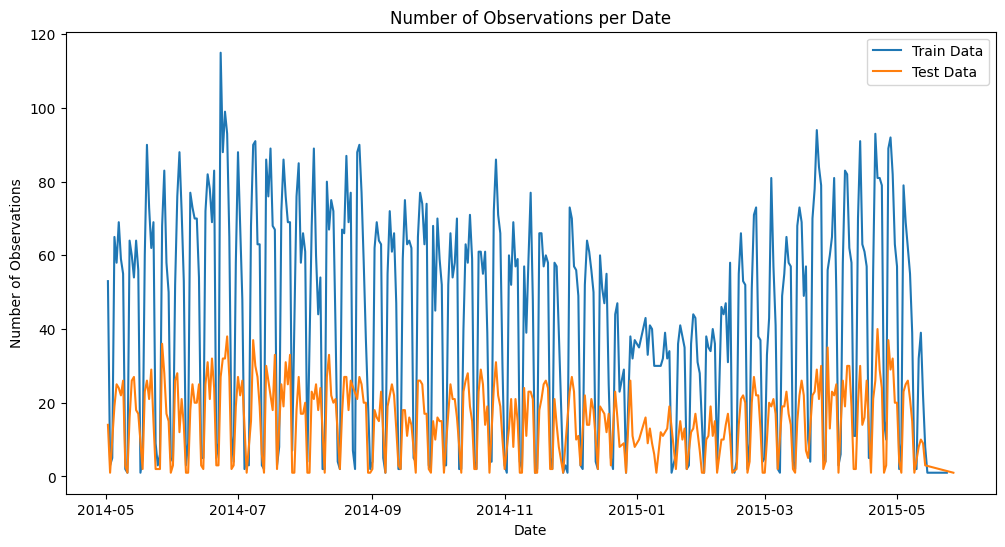

In [8]:
# test for Panel Data
# if dataset is Panel, then is there attrition in any entity over time?

# number of observations per date
obs_per_date_train = df_train['date'].value_counts().sort_index()
obs_per_date_test = df_test['date'].value_counts().sort_index()

#plot of observations per date using dot and line plot
plt.figure(figsize=(12,6))
plt.plot(obs_per_date_train.index, obs_per_date_train.values, label='Train Data')
plt.plot(obs_per_date_test.index, obs_per_date_test.values, label='Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Date')
plt.legend()
plt.show()

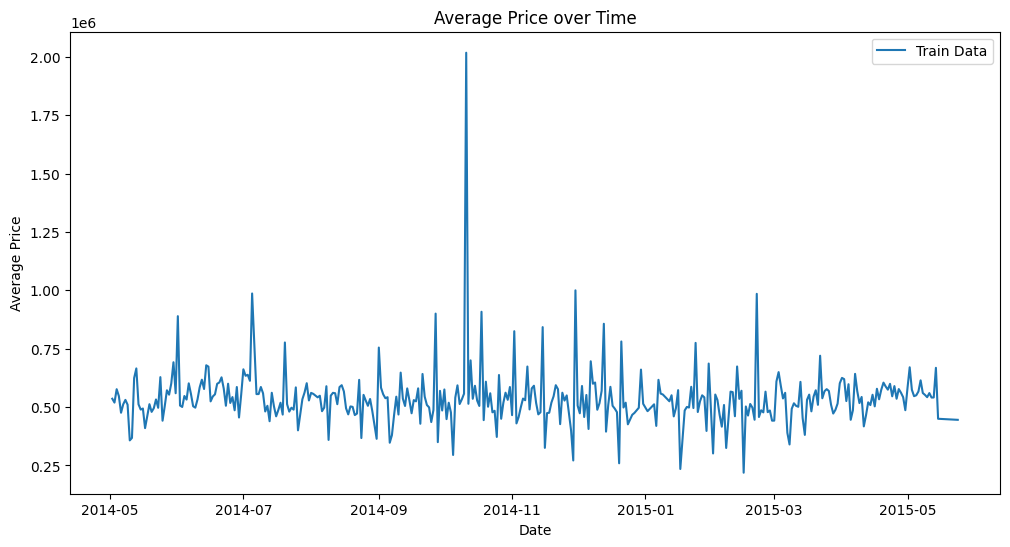

In [9]:
# temporal distribution of price over time
unique_dates_train = df_train['date'].unique()
avg_price_per_date_train = df_train.groupby('date')['price'].mean()

plt.figure(figsize=(12,6))
plt.plot(unique_dates_train, avg_price_per_date_train, label='Train Data')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price over Time')
plt.legend()
plt.show()

In [10]:
# Check for missing values
print("Missing values in train dataset : \n", df_train.isnull().sum())

Missing values in train dataset : 
 id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [11]:
# Number of 0 Values in each column
zero_counts = (df_train == 0).sum()
zero_counts

id                   0
date                 0
price                0
bedrooms             8
bathrooms            7
sqft_living          0
sqft_lot             0
floors               0
waterfront       16096
view             14604
condition            0
grade                0
sqft_above           0
sqft_basement     9882
yr_built             0
yr_renovated     15537
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

In [12]:
# Creating Spatial Features
# attaching this to the original dataframe
X = df_train[['lat', 'long']].values
df_train['spatial_cluster_8'] = KMeans(n_clusters=8, init='k-means++', random_state=42, n_init=10).fit_predict(X)

model = KMeans(n_clusters=8, init='k-means++', random_state=42, n_init=10).fit(X)

# for test data
X_test = df_test[['lat', 'long']].values
df_test['spatial_cluster_8'] = model.predict(X_test)

In [19]:
target = 'price'
features_num = list(set(df_train) - set(['price', 'date', 'id']))
categorical_features = [col for col in df_train.columns if df_train[col].nunique() <= 12 and col != target]
obs_bias_features = [col for col in df_train.columns if (df_train[col] == 0).sum() > 5000 and col != target]  # bias causing variables

In [20]:
# Solving the 0 value bias issue by replacing 0s
# 0 and categorical features
prob_featurex = [col for col in obs_bias_features if col in categorical_features]
print("Categorical features with 0 value bias : ", prob_featurex)
prob_feature_cont = [col for col in obs_bias_features if col not in categorical_features]
print("Continuous features with 0 value bias : ", prob_feature_cont)

Categorical features with 0 value bias :  ['waterfront', 'view', 'renovated', 'perks']
Continuous features with 0 value bias :  ['sqft_basement', 'yr_renovated']


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


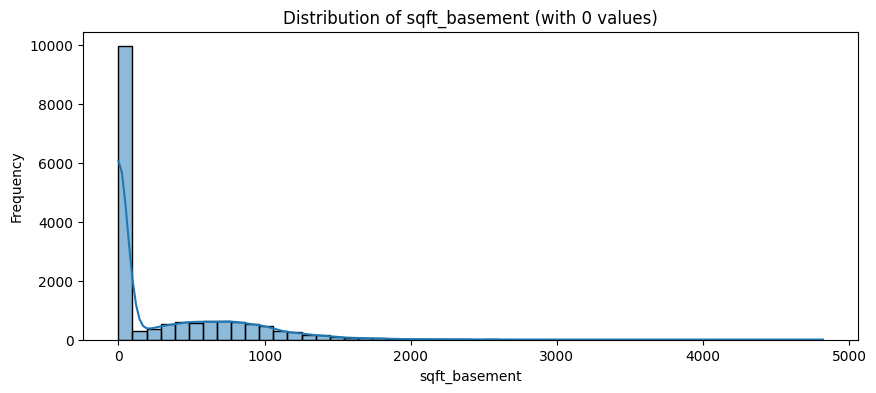

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


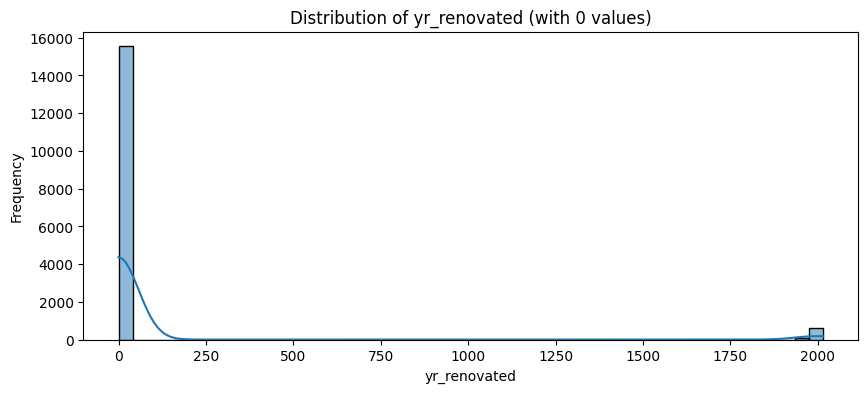

In [87]:
# Continuous features with 0 value plot
for col in prob_feature_cont:
    plt.figure(figsize=(10,4))
    sns.histplot(df_train[col], bins=50, kde=True)
    plt.title(f'Distribution of {col} (with 0 values)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

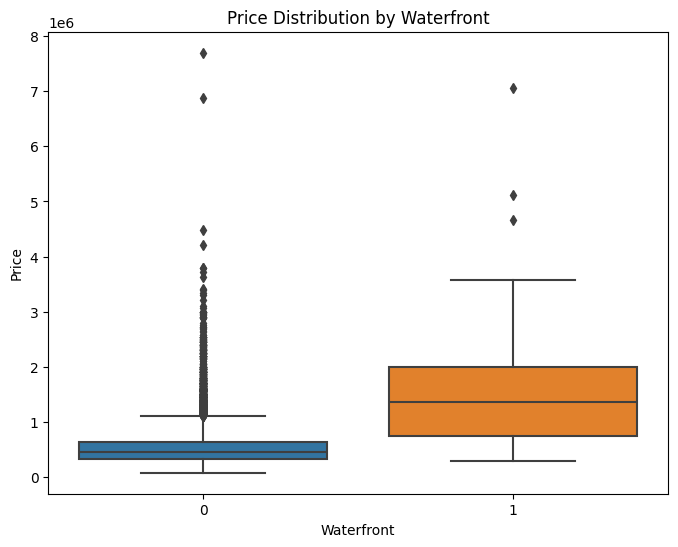

Text(0.5, 1.0, 'Price Distribution by View')

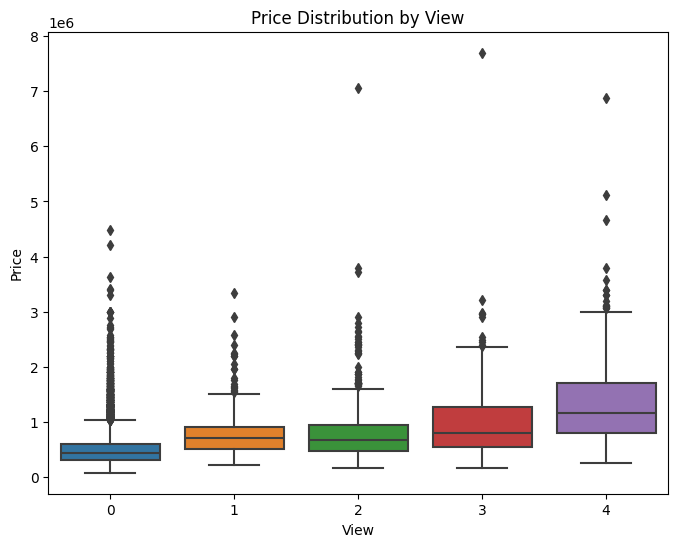

In [23]:
# relationship of waterfront and price
plt.figure(figsize=(8,6))
sns.boxplot(x='waterfront', y='price', data=df_train)
plt.title('Price Distribution by Waterfront')
plt.xlabel('Waterfront')
plt.ylabel('Price') 
plt.show()

# relationship with view and price
plt.figure(figsize=(8,6))
sns.boxplot(x='view', y='price', data=df_train)
plt.xlabel('View')
plt.ylabel('Price') 
plt.title('Price Distribution by View')

In [15]:
df_train['renovated'] = (df_train['yr_renovated'] > 0).astype(int)
df_test['renovated'] = (df_test['yr_renovated'] > 0).astype(int)

In [15]:
# test for PCA requirement
kmo_all, kmo_model = calculate_kmo(df_train[features_num])
print("KMO Model Value: ", kmo_model)
bartlett_chi2, bartlett_p_value = calculate_bartlett_sphericity(df_train[features_num])
print("Bartlett's Test Chi-square: ", bartlett_chi2)
print("Bartlett's Test p-value: ", bartlett_p_value)

KMO Model Value:  0.7521805730859604
Bartlett's Test Chi-square:  670399.3677569913
Bartlett's Test p-value:  0.0


c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [16]:
features_with_sqft = ['sqft_lot', 'sqft_lot15', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'bathrooms', 'grade', 'floors']

# Exploratory Factor Analysis
N_Features = 4 
scaler_2 = StandardScaler()
X_scaled = scaler_2.fit_transform(df_train[features_with_sqft])   
pca = PCA(n_components=N_Features)
X_pca = pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Explained Variance by each component: ", explained_variance)
print("Cumulative Explained Variance: ", cumulative_variance)

# Creating PCA features and attaching to original dataframe
pca_columns = [f'pca_sqft_{i+1}' for i in range(N_Features)]
df_pca_sqft = pd.DataFrame(pca.transform(X_scaled), columns=pca_columns)
df_train = pd.concat([df_train.reset_index(drop=True), df_pca_sqft.reset_index(drop=True)], axis=1)

# for test data
X_test_scaled = scaler_2.transform(df_test[features_with_sqft])
df_pca_sqft_test = pd.DataFrame(pca.transform(X_test_scaled), columns=pca_columns)
df_test = pd.concat([df_test.reset_index(drop=True), df_pca_sqft_test.reset_index(drop=True)], axis=1)

Explained Variance by each component:  [0.47752059 0.18696105 0.14781019 0.06777634]
Cumulative Explained Variance:  [0.47752059 0.66448164 0.81229183 0.88006817]


In [17]:
df_train['perks'] = df_train['waterfront'] + df_train['view'] + df_train['renovated']
df_test['perks'] = df_test['waterfront'] + df_test['view'] + df_test['renovated']

In [21]:
# One-hot encoding for categorical variables (0 and 1)
df_train_encoded = pd.get_dummies(df_train, columns=categorical_features, drop_first=True, dtype=int)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_features, drop_first=True, dtype=int)

In [22]:
df_train_encoded

,id,date,price,bathrooms,sqft_living,sqft_lot,sqft_above,sqft_basement,yr_built,yr_renovated,...,spatial_cluster_8_5,spatial_cluster_8_6,spatial_cluster_8_7,renovated_1,perks_1,perks_2,perks_3,perks_4,perks_5,perks_6
0,7525410190,2014-05-02,550000,1.75,2910,35200,2910,0,1979,0,...,0,0,0,0,0,0,0,0,0,0
1,5101405331,2014-05-02,495000,1.75,1600,6380,1130,470,1959,0,...,0,0,0,0,0,0,0,0,0,0
2,2771102144,2014-05-02,385000,3.25,1320,1327,1040,280,2008,0,...,0,0,0,0,0,0,0,0,0,0
3,4408100095,2014-05-02,308500,1.00,850,6174,850,0,1950,0,...,0,0,0,0,0,0,0,0,0,0
4,5056500260,2014-05-02,440000,2.25,2160,8119,1080,1080,1966,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16204,8149600265,2015-05-14,725000,1.75,1980,5850,1380,600,1960,0,...,0,0,0,0,1,0,0,0,0,0
16205,1786200010,2015-05-14,456500,2.50,2580,11780,2580,0,2003,0,...,0,1,0,0,0,0,0,0,0,0
16206,6752600320,2015-05-14,360000,2.50,2020,7289,2020,0,1994,0,...,0,0,0,0,0,0,0,0,0,0
16207,7923600250,2015-05-15,450000,2.00,1870,7344,1870,0,1960,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df_train_encoded.columns

Index(['id', 'date', 'price', 'bathrooms', 'sqft_living', 'sqft_lot',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'pca_sqft_1',
       'pca_sqft_2', 'pca_sqft_3', 'pca_sqft_4', 'bedrooms_1', 'bedrooms_2',
       'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7',
       'bedrooms_8', 'bedrooms_9', 'bedrooms_10', 'bedrooms_33', 'floors_1.5',
       'floors_2.0', 'floors_2.5', 'floors_3.0', 'floors_3.5', 'waterfront_1',
       'view_1', 'view_2', 'view_3', 'view_4', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'grade_10', 'grade_11',
       'grade_12', 'grade_13', 'spatial_cluster_8_1', 'spatial_cluster_8_2',
       'spatial_cluster_8_3', 'spatial_cluster_8_4', 'spatial_cluster_8_5',
       'spatial_cluster_8_6', 'spatial_cluster_8_7', 'renovated_1', 'perks_1',
       'perks_2', 'p

In [24]:
df_test_encoded.columns

Index(['id', 'date', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'pca_sqft_1', 'pca_sqft_2', 'pca_sqft_3',
       'pca_sqft_4', 'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4',
       'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_8', 'bedrooms_9',
       'bedrooms_10', 'bedrooms_11', 'floors_1.5', 'floors_2.0', 'floors_2.5',
       'floors_3.0', 'floors_3.5', 'waterfront_1', 'view_1', 'view_2',
       'view_3', 'view_4', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'spatial_cluster_8_1',
       'spatial_cluster_8_2', 'spatial_cluster_8_3', 'spatial_cluster_8_4',
       'spatial_cluster_8_5', 'spatial_cluster_8_6', 'spatial_cluster_8_7',
       'renovated_1', 'perks_1', 'perks_2', 'perks_3', 'perks_4', 'perks_5',
       

now since temporal nature oof price could be ignored in our case, we can randomize our dataset to remove any temporal bias

In [27]:
df_train_encoded['price'].mean()

537470.2827441545

c:\Users\pragy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


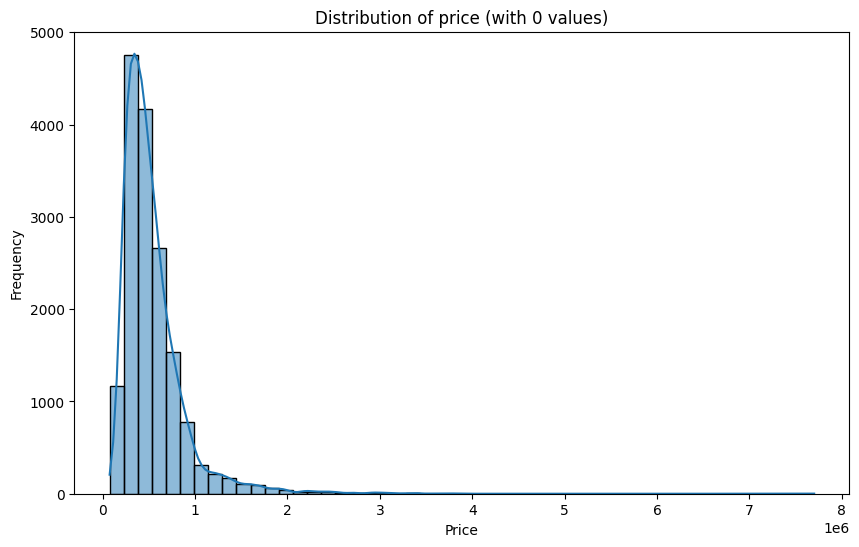

In [29]:
plt.figure(figsize = (10,6))
sns.histplot(df_train['price'], bins=50, kde=True)
plt.title(f'Distribution of price (with 0 values)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df_test_encoded['grade_3'] = 0
df_test_encoded['grade_4'] = 0
df_test_encoded['bedrooms_33'] = 0

In [19]:
# Would the colour of the house impact the price?
# Let's see the distribution of price based on the 'waterfront' feature

In [20]:
# Attaching Images to the dataset

In [26]:
df_train.to_csv(data_path + '/cleaned_train.csv', index=False)
df_test.to_csv(data_path + '/cleaned_test.csv', index=False)

df_train_encoded.to_csv(data_path + '/encoded_train.csv', index=False)
df_test_encoded.to_csv(data_path + '/encoded_test.csv', index=False)